In [49]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np
import os
from glob import glob
import re
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Statistical Analysis and Time Series
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf
# Machine Learning and Explainability
import shap
import lightgbm as lgb
# Utilities
import warnings
import random
import gc
# Notebook settings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None 
#pd.options.display.max_rows = None
pd.reset_option("display.max_rows")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [50]:
# Data Path
DATA_PATH = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"

# Automatically detect partitions instead of manually specifying them
partition_paths = sorted(glob(os.path.join(DATA_PATH, "partition_id=*/part-*.parquet")))

# Select a range of files
FIRST_PARTITIONS_TO_LOAD = 0
LAST_PARTITIONS_TO_LOAD = 1
selected_files = partition_paths[FIRST_PARTITIONS_TO_LOAD:LAST_PARTITIONS_TO_LOAD]

# Use a list comprehension to read the parquet files
dataframes = [pd.read_parquet(file) for file in selected_files]

train_df = pd.concat(dataframes, ignore_index=True)

print("Loaded shape:", train_df.shape)
train_df.head()

Loaded shape: (1944210, 92)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,0.242971,0.263400,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,NaN,-0.169586,NaN,-1.335938,-1.707803,0.910130,NaN,1.636431,1.522133,-1.551398,-0.229627,NaN,NaN,1.378301,-0.283712,0.123196,NaN,NaN,NaN,0.281180,0.269163,0.349028,-0.012596,-0.225932,NaN,-1.073602,NaN,NaN,-0.181716,NaN,NaN,NaN,0.564021,2.088506,0.832022,NaN,0.204797,NaN,NaN,-0.808103,NaN,-2.037683,0.727661,NaN,-0.989118,-0.345213,-1.36224,NaN,NaN,NaN,NaN,NaN,-1.251104,-0.110252,-0.491157,-1.022690,0.152241,-0.659864,NaN,NaN,-0.261412,-0.211486,-0.335556,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,NaN,0.317467,NaN,-1.250016,-1.682929,1.412757,NaN,0.520378,0.744132,-0.788658,0.641776,NaN,NaN,0.227200,0.580907,1.128879,NaN,NaN,NaN,-1.512286,-1.414357,-1.823322,-0.082763,-0.184119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835207,-0.002704,-0.621836,NaN,1.172836,NaN,NaN,-1.625862,NaN,-1.410017,1.063013,NaN,0.888355,0.467994,-1.36224,NaN,NaN,NaN,NaN,NaN,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,NaN,NaN,-0.281207,-0.182894,-0.245565,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,0.187227,0.249901,-0.773050,11,7,76,-0.675719,-0.199404,-0.586798,NaN,-0.814909,NaN,-1.296782,-2.040234,0.639589,NaN,1.597359,0.657514,-1.350148,0.364215,NaN,NaN,-0.017751,-0.317361,-0.122379,NaN,NaN,NaN,-0.320921,-0.958090,-2.436589,0.070999,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420632,-3.515137,-4.677760,NaN,0.535897,NaN,NaN,-0.725420,NaN,-2.294170,1.764551,NaN,-0.120789,-0.063458,-1.36224,NaN,NaN,NaN,NaN,NaN,-0.882604,-0.072482,-0.617934,-0.863230,-0.241892,-0.709919,NaN,NaN,0.377131,0.300724,-0.106842,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,NaN,-0.251882,NaN,-1.902009,-0.979447,0.241165,NaN,-0.392359,-0.224699,-2.129397,-0.855287,NaN,NaN,0.404142,-0.578156,0.105702,NaN,NaN,NaN,0.544138,-0.087091,-1.500147,-0.201288,-0.038042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382074,2.669135,0.611711,NaN,2.413415,NaN,NaN,1.313203,NaN,-0.810125,2.939022,NaN,3.988801,1.834661,-1.36224,NaN,NaN,NaN,NaN,NaN,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,NaN,NaN,-0.226891,-0.251412,-0.215522,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,0.262404,0.344457,-0.613813,44,3,16,-0.947351,-0.030018,-0.502379,NaN,0.646086,NaN,-1.844685,-1.586560,-0.182024,NaN,-0.969949,-0.673813,-1.282132,-1.399894,NaN,NaN,0.043815,-0.320225,-0.031713,NaN,NaN,NaN,-0.088420,-0.995003,-2.635336,-0.196461,-0.618719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.014600,-2.321076,-3.711265,N

In [51]:
train_df['date_id']

0            0
1            0
2            0
3            0
4            0
          ... 
1944205    169
1944206    169
1944207    169
1944208    169
1944209    169
Name: date_id, Length: 1944210, dtype: int16

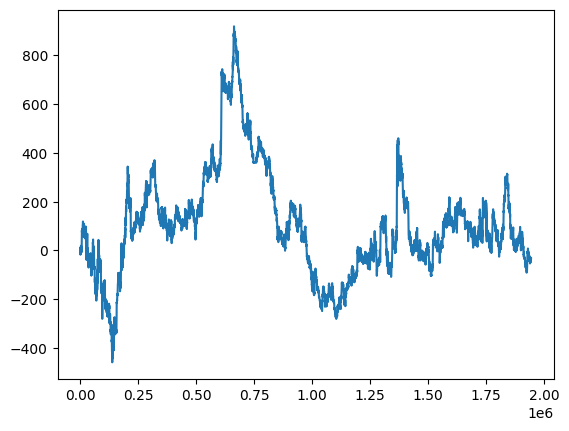

In [52]:
symbol= train_df[train_df['symbol_id']==1]
x = symbol.index
cum_sum = symbol['responder_6'].cumsum()
plt.plot(x,cum_sum)

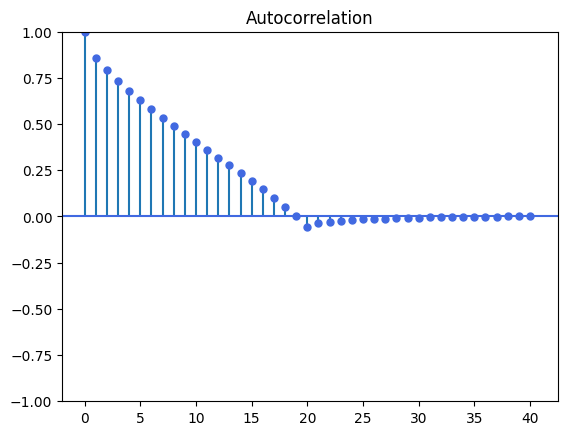

In [53]:
target = symbol['responder_6']
plot_acf(target, lags=40, color="royalblue", alpha=0.8)
plt.show()

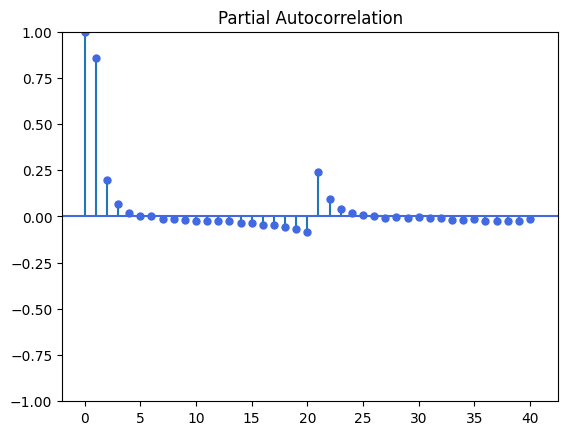

In [54]:
plot_pacf(target, lags=40, color="royalblue", alpha=0.8)
plt.show()

In [55]:
df = symbol[['date_id','responder_6']]

In [56]:
# 1️⃣ إنشاء المتوسط لكل date_id
grouping = (
    df.groupby('date_id')['responder_6'].mean()
      .reindex(range(df['date_id'].min(), df['date_id'].max() + 1)).reset_index()
      .rename(columns={'index': 'date_id'})
)

# 2️⃣ ملء القيم المفقودة بطريقة أكثر كفاءة (باستخدام rolling)
grouping['responder_6'] = grouping['responder_6'].fillna(
    grouping['responder_6'].rolling(window=5, min_periods=1, center=True).mean()
)

# 3️⃣ عرض النتائج
print(grouping.head(10))


   date_id  responder_6
0        0     0.003583
1        1     0.086939
2        2    -0.053247
3        3    -0.108113
4        4     0.005478
5        5     0.093234
6        6    -0.190955
7        7    -0.018426
8        8     0.201796
9        9    -0.114892


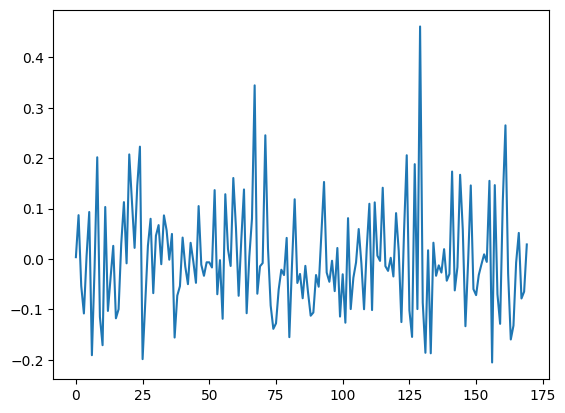

In [57]:
x = grouping['date_id'].index
y = grouping['responder_6']
plt.plot(x,y)

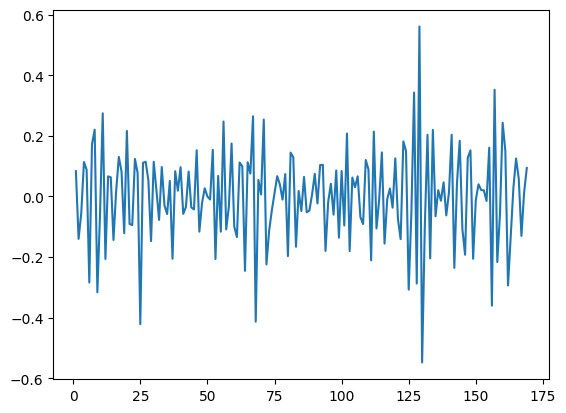

In [60]:
x = grouping['date_id'].index
y = grouping['responder_6'].diff()
plt.plot(x,y)

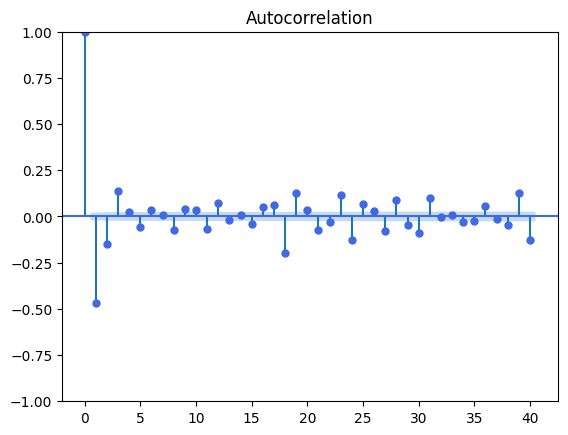

In [61]:
y = y.dropna()
plot_acf(y, lags=40, color="royalblue", alpha=0.8)
plt.show()

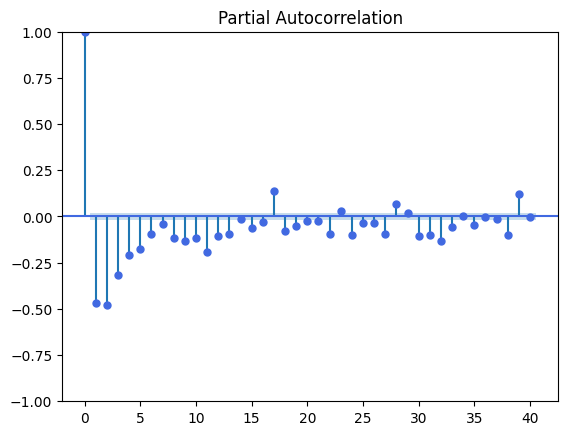

In [12]:
plot_pacf(y, lags=40, color="royalblue", alpha=0.8)
plt.show()

In [65]:
train_data = y.iloc[0:150]
test_data = y.iloc[150:]

In [66]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(6,0,2))
#fit the model
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            responder_6   No. Observations:                  150
Model:                 ARIMA(6, 0, 2)   Log Likelihood                 127.350
Date:                Sat, 25 Oct 2025   AIC                           -234.700
Time:                        14:06:41   BIC                           -204.594
Sample:                             0   HQIC                          -222.469
                                - 150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.532e-06      0.000     -0.025      0.980      -0.001       0.001
ar.L1         -0.8050      1.512     -0.532      0.594      -3.768       2.158
ar.L2         -0.2242      0.183     -1.225      0.2

In [67]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [68]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

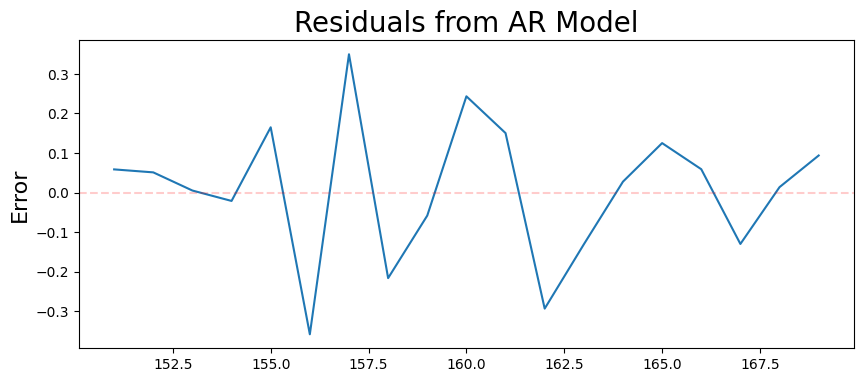

In [69]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

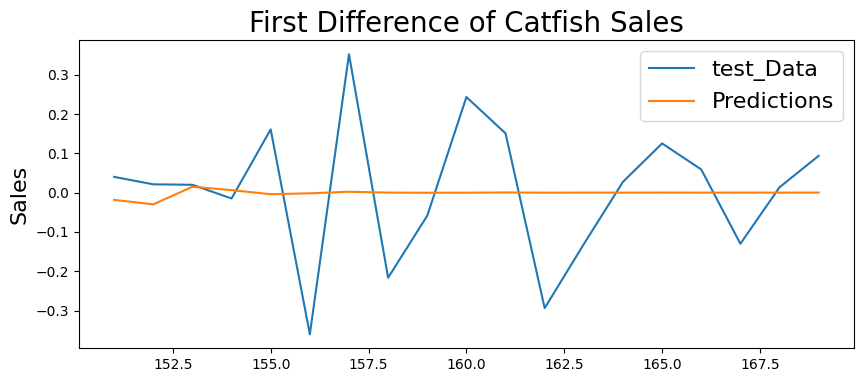

In [70]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('test_Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [71]:
mae = mean_absolute_error(test_data, predictions)
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_data, predictions)
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

MAE  : 0.1343
MSE  : 0.0298
RMSE : 0.1726
R²   : -0.0049


**rolling forcasting**

RMSE: 0.1726
MAE  : 0.0942
MSE  : 0.0140
RMSE : 0.1181
R²   : 0.5293


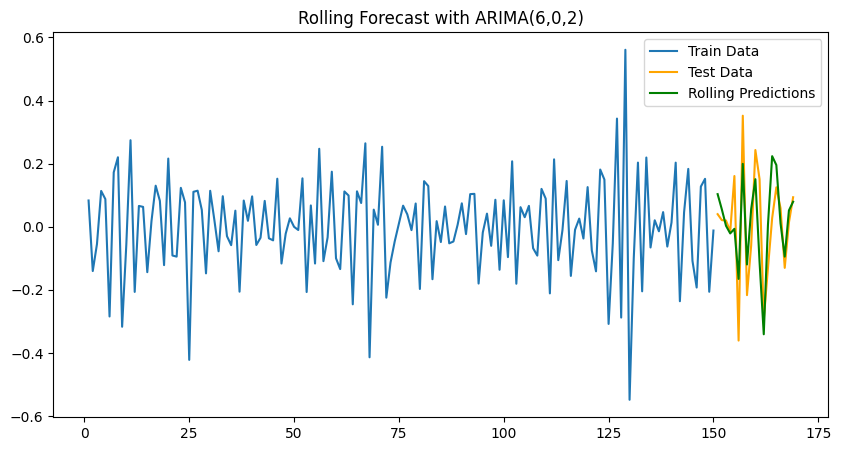

In [72]:
# قائمة لتخزين التنبؤات
rolling_predictions = []

# rolling forecast
for i in range(len(test_data)):
    # كل مرة نزيد نقطة واحدة في التدريب
    train = y.iloc[:150 + i]
    
    # بناء النموذج
    model = ARIMA(train, order=(6,0,2))
    model_fit = model.fit()
    
    # التنبؤ بفترة واحدة
    pred = model_fit.forecast().iloc[0]
    
    # حفظ التنبؤ
    rolling_predictions.append(pred)

# تحويل التنبؤات إلى Series بفهرس test_data
rolling_predictions = pd.Series(rolling_predictions, index=test_data.index)

# حساب 
mae = mean_absolute_error(test_data, rolling_predictions)
mse = mean_squared_error(test_data, rolling_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_data, rolling_predictions)
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")
# رسم النتائج
plt.figure(figsize=(10,5))
plt.plot(train_data, label='Train Data')
plt.plot(test_data, label='Test Data', color='orange')
plt.plot(rolling_predictions, label='Rolling Predictions', color='green')
plt.title('Rolling Forecast with ARIMA(6,0,2)')
plt.legend()
plt.show()


In [ ]:
rolling_forcasting = []

for i in range(len(test_data)):
    train = y.iloc(:len(train_data)+i)
    model = ARIMA(train_data,order=(6,0,2))
    model_fit = model.fit()
    pred  = model_fit.forcaset.iloc[0]
    rolling_forcasting.append(pred)
rolling_forcasting = pd.Series(rolling_forcasting,index=test_data.index)

MAE  : 0.1061
MSE  : 0.0198
RMSE : 0.1408
R²   : 0.2609


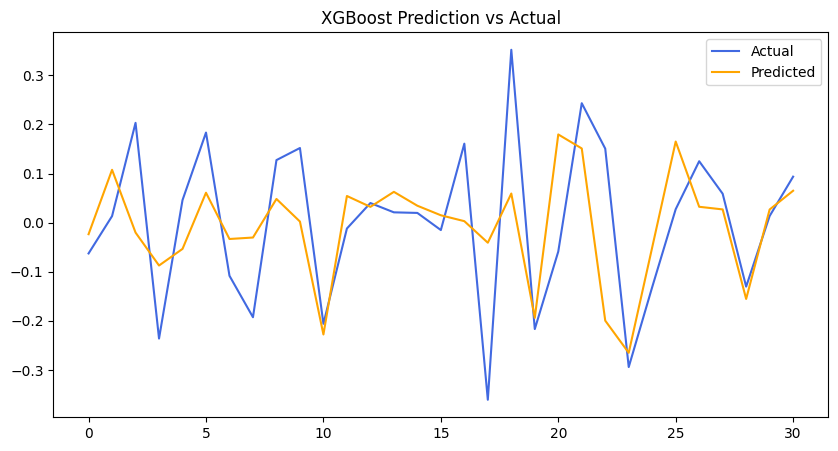

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# ==============================
# 🔹 1. تجهيز البيانات
# ==============================
grouping = df.groupby('date_id')['responder_6'].mean()
full_range = np.arange(grouping.index.min(), grouping.index.max() + 1)
grouping = grouping.reindex(full_range).reset_index()
grouping.columns = ['date_id', 'responder_6']

# دالة لملء القيم المفقودة بمتوسط آخر قيمتين وقيمتين تاليتين
def fill_with_neighbors_mean(series, window=2):
    s = series.copy()
    for i in range(len(s)):
        if pd.isna(s[i]):
            start = max(0, i - window)
            end = min(len(s), i + window + 1)
            neighbors = s[start:end].dropna()
            if len(neighbors) > 0:
                s[i] = neighbors.mean()
    return s

grouping['responder_6'] = fill_with_neighbors_mean(grouping['responder_6'])

# نستخدم الفرق (التغير اليومي)
y = grouping['responder_6'].diff().dropna().reset_index(drop=True)

# ==============================
# 🔹 2. إنشاء ميزات (Features)
# ==============================
def create_features(y, lag=10):
    X = []
    Y = []
    for i in range(lag, len(y)):
        X.append(y[i-lag:i].values)  
        Y.append(y[i])
    return np.array(X), np.array(Y)

X, Y = create_features(y, lag=14)

# ==============================
# 🔹 3. تقسيم البيانات زمنياً
# ==============================
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = Y[:split], Y[split:]

# ==============================
# 🔹 4. تدريب XGBoost
# ==============================
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# ==============================
# 🔹 5. التنبؤ والتقييم
# ==============================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# ==============================
# 🔹 6. الرسم البياني للمقارنة
# ==============================
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual', color='royalblue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.title('XGBoost Prediction vs Actual')
plt.legend()
plt.show()


In [85]:
df = symbol[['date_id','responder_6']]

In [86]:
import pandas as pd

# حدد تاريخ البداية اللي يناسبك
start_date = pd.Timestamp("2020-01-01")

# تحويل date_id إلى تواريخ حقيقية
df["date"] = start_date + pd.to_timedelta(df["date_id"], unit="D")

# نشوف أول القيم بعد التحويل
print(df.head())

    date_id  responder_6       date
0         0     0.775981 2020-01-01
8         0     0.751976 2020-01-01
16        0     1.163832 2020-01-01
24        0     0.961646 2020-01-01
32        0     0.625693 2020-01-01


In [87]:
grouping = (
    df.groupby('date')['responder_6'].mean()
    .reindex(
        pd.date_range(df['date'].min(), df['date'].max(), freq='D')  # ← هنا التعديل
    )
    .reset_index()
    .rename(columns={'index': 'date'})
)

# 2️⃣ ملء القيم المفقودة بطريقة أكثر كفاءة (باستخدام rolling)
grouping['responder_6'] = grouping['responder_6'].fillna(
    grouping['responder_6'].rolling(window=5, min_periods=1, center=True).mean()
)

# 3️⃣ عرض النتائج
print(grouping.head(10))


        date  responder_6
0 2020-01-01     0.003583
1 2020-01-02     0.086939
2 2020-01-03    -0.053247
3 2020-01-04    -0.108113
4 2020-01-05     0.005478
5 2020-01-06     0.093234
6 2020-01-07    -0.190955
7 2020-01-08    -0.018426
8 2020-01-09     0.201796
9 2020-01-10    -0.114892


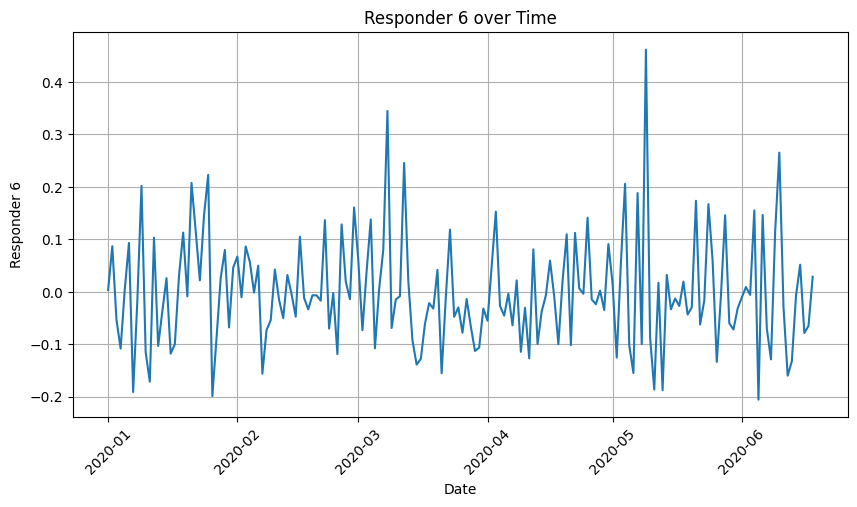

In [88]:
x = grouping['date']
target = grouping['responder_6']

plt.figure(figsize=(10,5))
plt.plot(x, target)
plt.xlabel('Date')
plt.ylabel('Responder 6')
plt.title('Responder 6 over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [89]:
avg, dev = target.mean(), target.std()

In [90]:
target = (target - avg) / dev

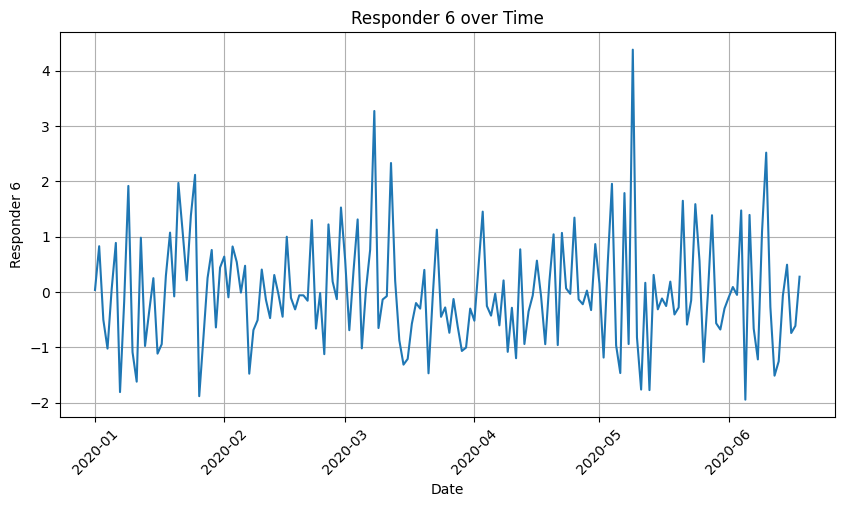

In [91]:
plt.figure(figsize=(10,5))
plt.plot(x, target)
plt.xlabel('Date')
plt.ylabel('Responder 6')
plt.title('Responder 6 over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [92]:
grouping['responder_6'] = grouping['responder_6'].diff()

In [93]:
grouping.dropna()

,date,responder_6
1,2020-01-02,0.083357
2,2020-01-03,-0.140186
3,2020-01-04,-0.054866
4,2020-01-05,0.113591
5,2020-01-06,0.087756
...,...,...
165,2020-06-14,0.125102
166,2020-06-15,0.058912
167,2020-06-16,-0.130131
168,2020-06-17,0.013593


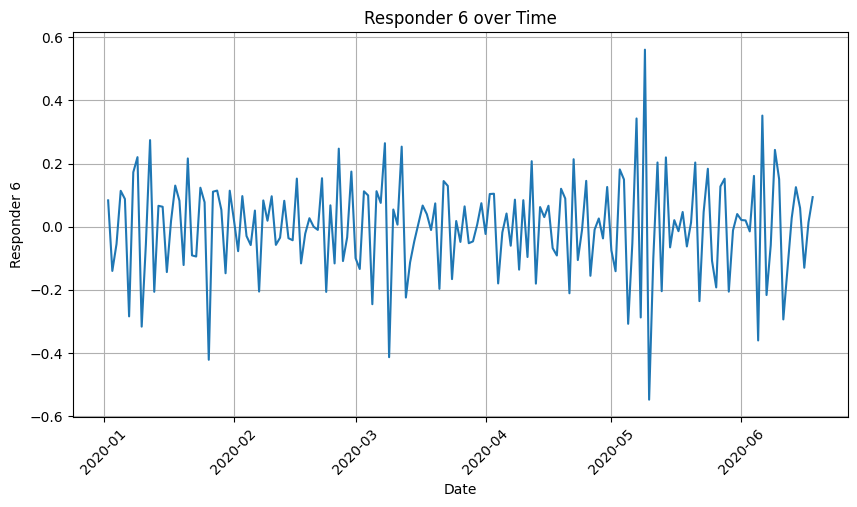

In [94]:
plt.figure(figsize=(10,5))
plt.plot(x,grouping['responder_6'] )
plt.xlabel('Date')
plt.ylabel('Responder 6')
plt.title('Responder 6 over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [95]:
#ذه الطريقة تقلل حجم الفروق بين القيم الكبيرة والصغيرة.
#لكن لا تستخدمها لو عندك قيم سالبة أو صفرية بدون معالجة مسبقة.
grouping["responder_6_log"] = np.log1p(grouping["responder_6"])

In [99]:
avg, std = grouping["responder_6"].mean(), grouping["responder_6"].std()
grouping["responder_6_scaled"] = (grouping["responder_6"] - avg) / std

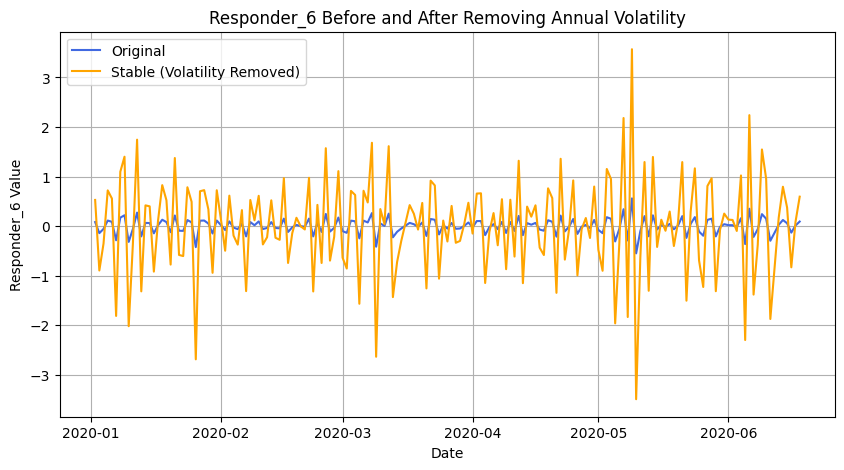

In [100]:
plt.figure(figsize=(10,5))
plt.plot(grouping['date'], grouping['responder_6'], label='Original', color='royalblue')
plt.plot(grouping['date'], grouping["responder_6_scaled"], label='Stable (Volatility Removed)', color='orange')
plt.title('Responder_6 Before and After Removing Annual Volatility')
plt.xlabel('Date')
plt.ylabel('Responder_6 Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
